In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys
import scipy

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.GalKin.galkin import Galkin
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Profiles.multi_gaussian_kappa import MultiGaussianKappa
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Util import param_util
import lenstronomy.Util.multi_gauss_expansion as mge


In [2]:
#a few functions to make different settings more readable
center_x,center_y=0,0

#function to create chameleon profile corresponding to a given sersic profile
def sersic_to_chameleon(kwargs_sersic,light=True):#either light=True or if using a mass profile, light=False
#     e1=0.0;e2=0 #spherical for light so that it can go into hierarc
    e1=kwargs_sersic['e1']
    e2=kwargs_sersic['e2']
    n_sersic=kwargs_sersic['n_sersic']
    if n_sersic==4:
        b_n=7.669
    else:
        sys.exit('Error: n_sersic not supported')
    r_eff=kwargs_sersic['R_sersic']
    center_x=kwargs_sersic['center_x'];center_y=kwargs_sersic['center_y']
    #from Dutton et al, calculate desired conversion from sersic
    def sersic2cham_R0(R0_sersic,n):
        x0=1.15
        y0=0.078
        y1=-0.184
        y2=0.473
        y3=-0.079
        y=y0+y1*(n-x0)+y2*(n-x0)**2+y3*(n-x0)**3
        return R0_sersic*10**y
    def sersic2cham_alpha(n):
        x0=2.03
        y0=-0.739
        y1=-0.527
        y2=-0.012
        y3=-0.008
        y=y0+y1*(n-x0)+y2*(n-x0)**2+y3*(n-x0)**3
        return 10**y 
    R0_sersic=r_eff/(b_n**n_sersic)
    dutton_R0=sersic2cham_R0(R0_sersic,n_sersic)
    dutton_alpha=sersic2cham_alpha(n_sersic)
    dutton_alpha=dutton_alpha/1.5; print('modified alpha from Dutton et al.')
    kwargs_chameleon={'amp':1, 'w_c':dutton_R0, 'w_t':dutton_R0/dutton_alpha, 'e1':e1, 'e2':e2, 'center_x':center_x, 'center_y':center_y}
    if not light:
        
        e1=kwargs_sersic['e1']
        e2=kwargs_sersic['e2']
        q_lens=param_util.ellipticity2phi_q(e1,e2)[1]
        print(q_lens)
        Lens_sersic = LensModel(lens_model_list=['SERSIC_ELLIPSE_KAPPA'])
        defl_1=Lens_sersic.alpha(1/np.sqrt(q_lens),0,[kwargs_sersic])[0] #deflection at 1" used as normalization for lenstronomy Chameleon
        kwargs_chameleon={'alpha_1':float(defl_1), 'w_c':dutton_R0, 'w_t':dutton_R0/dutton_alpha, 'e1':e1, 'e2':e2, 'center_x':center_x, 'center_y':center_x}
    return kwargs_chameleon

def mge_mass(lens_model_list,kwargs_mass):
    ncomp_max=30
    LensMod = LensModel(lens_model_list)
    LensAn = LensProfileAnalysis(LensMod)
    amps, sigmas, center_x_mge, center_y_mge=LensAn.multi_gaussian_lens(kwargs_mass, center_x=center_x, 
                                                                      center_y=center_y, model_bool_list=None, 
                                                                      n_comp=ncomp_max)
    lens_model_list_mge = ['MULTI_GAUSSIAN_KAPPA']
    kwargs_mass_mge = [{'amp': amps, 'sigma': sigmas}]
    return lens_model_list_mge,kwargs_mass_mge
def mge_light(lens_light_model_list,kwargs_light):
    ncomp_max=30
    LensLightModel=LightModel(light_model_list=lens_light_model_list)
    lensLightProfile = LightProfileAnalysis(light_model=LensLightModel)
    amps, sigmas, center_x_mge, center_y_mge = lensLightProfile.multi_gaussian_decomposition(
                kwargs_light, center_x=center_x, center_y=center_y, n_comp=ncomp_max)
    lens_light_model_list_mge = ['MULTI_GAUSSIAN']
    kwargs_light_mge = [{'amp': amps, 'sigma': sigmas}]
    return lens_light_model_list_mge,kwargs_light_mge

#function to plot sigma
def sigma_r_plot(result_,ax=None,label=None,color='C0',linestyle='-'):
    if ax==None: #make new figure
        fig,ax=plt.subplots(1,1,figsize=(7,7))
    plot_r=result_['plot_r']
    sig_proj=result_['sig_proj']
    ax.semilogx(plot_r,sig_proj,label=label,color=color,linestyle=linestyle,alpha=0.7)
    vel_disp_ap=result_['v_disp_aperture']
    ax.scatter(rbins_aperture[1:],vel_disp_ap,color=color)
    ax.set_ylim([200,300])
    ax.set_ylabel(r'$\sigma_v$',fontsize=16)
    ax.set_xlabel(r'R [arcsec]',fontsize=16)
    plt.legend()
    

modified alpha from Dutton et al.
0.8181818181818181
modified alpha from Dutton et al.
Using these settings for v_disp measurement:
['CHAMELEON', 'NFW_ELLIPSE'] ['CHAMELEON']


/home/gomer/miniconda3/envs/lenstro_branch/lib/python3.8/site-packages/lenstronomy/GalKin/light_profile.py:112: RuntimeWarning: invalid value encountered in sqrt
  stop = np.log10(np.maximum(np.sqrt(self._max_interpolate**2 - R**2), self._min_interpolate + 0.00001))


Using these settings for v_disp measurement:
['MULTI_GAUSSIAN_KAPPA'] ['CHAMELEON']
Using these settings for v_disp measurement:
['CHAMELEON', 'NFW_ELLIPSE'] ['MULTI_GAUSSIAN']
Using these settings for v_disp measurement:
['MULTI_GAUSSIAN_KAPPA'] ['MULTI_GAUSSIAN']


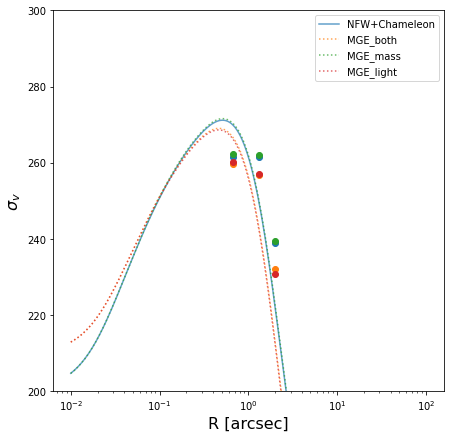

In [3]:
#galkin model settings:
cosmo = FlatLambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0.3)

kwargs_numerics = {'interpol_grid_num': 5000, 'log_integration': True,
                          'max_integrate': 4000, 'min_integrate': 0.001}
anisotropy_type = 'OM'

psf_fwhm=0.7
kwargs_seeing={'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}
rbins_aperture= np.linspace(0, 2, 4)
kwargs_aperture = {'aperture_type': 'IFU_shells', 'r_bins':rbins_aperture, 'center_ra': center_x,'center_dec':center_y}

z_l=0.25; z_s=0.6
kpcperarcsec=cosmo.kpc_proper_per_arcmin(z_l).to (u.kpc/u.arcsec)
lensCosmo = LensCosmo(z_l, z_s, cosmo=cosmo)
kwargs_cosmo = {'d_d': lensCosmo.dd, 'd_s': lensCosmo.ds, 'd_ds': lensCosmo.dds}

plot_r = np.logspace(-2, 2, 200) 
#Define function to calculate all quantities for plots:
def galkin_quantities(lens_model_list, lens_light_model_list,kwargs_mass,kwargs_light,kwargs_anisotropy):
    #also uses anisotropy_type, kwargs_aperture, kwargs_seeing,kwargs_cosmo, kwargs_numerics, plot_r
    print('Using these settings for v_disp measurement:')
    print(lens_model_list,lens_light_model_list)
    galkin=Galkin({'mass_profile_list': lens_model_list, 'light_profile_list': lens_light_model_list,
                   'anisotropy_model': anisotropy_type}, kwargs_aperture=kwargs_aperture,
                  kwargs_psf=kwargs_seeing, analytic_kinematics=False,
                  kwargs_cosmo=kwargs_cosmo, kwargs_numerics=kwargs_numerics)
    
    mass_3d=((galkin.numerics.mass_3d(plot_r,kwargs_mass)*u.kg).to(u.solMass)).value #mass_3d converted from kg to solmass    
    LensMod = LensModel(lens_model_list)
    LensAn = LensProfileAnalysis(LensMod)
    theta_E = LensAn.effective_einstein_radius(kwargs_mass, center_x=0, center_y=0,
                                                            grid_num=400, grid_spacing=0.025,
                                              get_precision=False, verbose=True)
#     print('theta_E= ',theta_E)
    kappa_profile=np.zeros_like(plot_r)
    kappa_slope=np.zeros_like(plot_r)
    xi=np.zeros_like(plot_r)
    sig_proj=np.zeros_like(plot_r)
    for r_index, rad in enumerate(plot_r):
        xi[r_index]=LensAn.mst_invariant_differential(kwargs_mass, rad, center_x=center_x, center_y=center_y,
                                                   num_points=20)
        kappa_slope[r_index] = LensAn.profile_slope(kwargs_mass, rad, center_x=center_x, center_y=center_y,
                                                   num_points=20)
        sig_proj[r_index]=np.sqrt(galkin.numerics.sigma_s2_project(rad,kwargs_mass,kwargs_light,kwargs_anisotropy)[0])/1000
    kappa_profile=LensAn.radial_lens_profile(plot_r, kwargs_mass, center_x=center_x, center_y=center_y)
    LensLightModel=LightModel(light_model_list=lens_light_model_list)
    lensLightProfile = LightProfileAnalysis(light_model=LensLightModel)
    light_profile=lensLightProfile.radial_light_profile(plot_r,kwargs_light,center_x=center_x, center_y=center_y)
    v_disp_aperture = galkin.dispersion_map(kwargs_mass, kwargs_light, kwargs_anisotropy,
                            num_kin_sampling=2000)
    return {'plot_r': plot_r, 'v_disp_aperture': v_disp_aperture, 'sig_proj': sig_proj,
            'kappa_profile': kappa_profile, 'kappa_slope': kappa_slope, 'xi': xi, 
            'mass_3d': mass_3d, 'light_profile': light_profile}    

#input lens
e1=0.1;e2=0
r_eff=2
kwargs_sersic={'k_eff': 0.1, 'R_sersic': r_eff, 'n_sersic': 4, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
lens_model_list=['CHAMELEON', 'NFW_ELLIPSE']
kwargs_chameleon=sersic_to_chameleon(kwargs_sersic,light=False)
kwargs_nfw={'Rs': 11, 'alpha_Rs': 0.6, 'e1': 0.1, 'e2': 0.0, 'center_x': center_x, 'center_y': center_y}
kwargs_mass=[kwargs_chameleon, kwargs_nfw]
lens_light_model_list=['CHAMELEON']
kwargs_light=[sersic_to_chameleon(kwargs_sersic,light=True)]

#anisotropy radius
if anisotropy_type=='OM':
#     a_ani=1; r_ani=a_ani*r_eff  #could define using a_ani if you prefer
    r_ani=2
    kwargs_anisotropy = {'r_ani':r_ani}
if anisotropy_type=='isotropic':
    kwargs_anisotropy={}

#Calculate using galkin
result_orig= galkin_quantities(lens_model_list, lens_light_model_list,kwargs_mass,kwargs_light,kwargs_anisotropy)

#MGE mass
lens_model_list_mge,kwargs_mass_mge=mge_mass(lens_model_list,kwargs_mass)
result_mgemass= galkin_quantities(lens_model_list_mge, lens_light_model_list,kwargs_mass_mge,kwargs_light,kwargs_anisotropy)
#MGE light
lens_light_model_list_mge,kwargs_light_mge=mge_light(lens_light_model_list,kwargs_light)
result_mgelight= galkin_quantities(lens_model_list, lens_light_model_list_mge,kwargs_mass,kwargs_light_mge,kwargs_anisotropy)
#both
result_mgeboth= galkin_quantities(lens_model_list_mge, lens_light_model_list_mge,kwargs_mass_mge,kwargs_light_mge,kwargs_anisotropy)


#plot sigma
fig,ax=plt.subplots(1,1,figsize=(7,7))
sigma_r_plot(result_orig,ax=ax,label='NFW+Chameleon',color='C0',linestyle='-')
sigma_r_plot(result_mgeboth,ax=ax,label='MGE_both',color='C1',linestyle=':')
sigma_r_plot(result_mgemass,ax=ax,label='MGE_mass',color='C2',linestyle=':')
sigma_r_plot(result_mgelight,ax=ax,label='MGE_light',color='C3',linestyle=':')

plt.show()

#plot all 5 or however many plots as residuals, but not sigma_r